In [47]:
import numpy as np
import matplotlib.pyplot as plt

Ex = np.loadtxt("../main_files/Ex_t.dat")
f = np.loadtxt("../main_files/f.dat")
t = np.arange(Ex.shape[0])


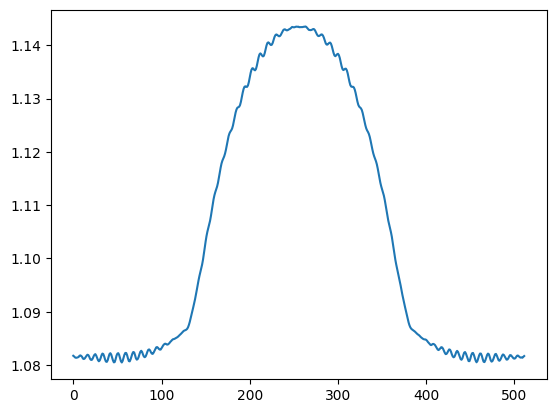

In [46]:
plt.plot(f[9000,:])

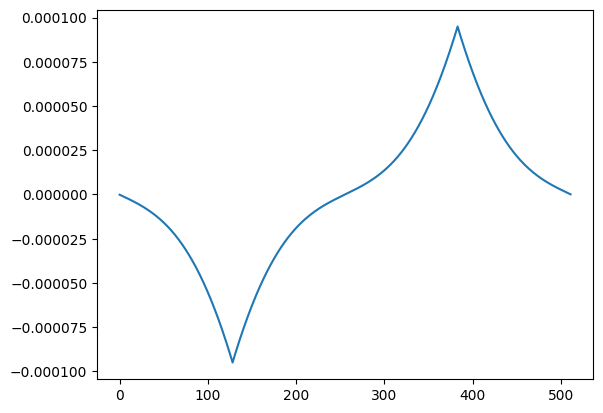

In [41]:
plt.plot(Ex[2900,:])


In [55]:
t_fit = t[10:50]
logE = np.log(Emax[10:50])

coef = np.polyfit(t_fit, logE, 1)
gamma_num = coef[0]

print("measured gamma =", gamma_num)

measured gamma = 0.03632814946244517


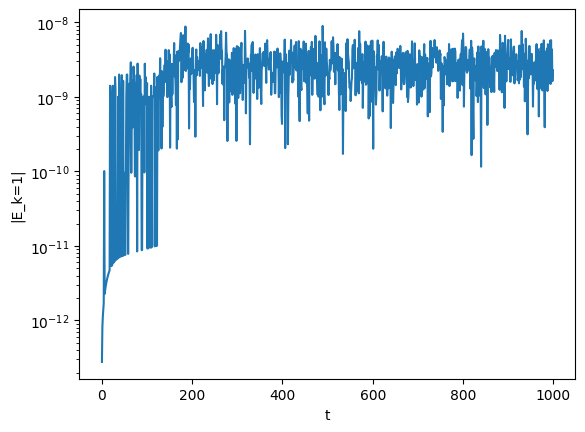

In [32]:
Exk = np.fft.fft(Ex, axis=1)
Ek1 = np.abs(Exk[:,20])

plt.semilogy(t, Ek1)
plt.xlabel("t")
plt.ylabel("|E_k=1|")
plt.show()


MovieWriter ffmpeg unavailable; using Pillow instead.


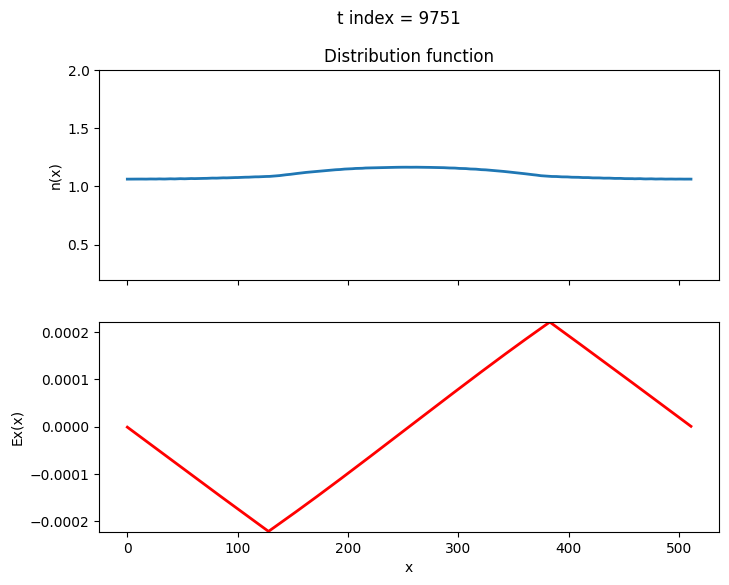

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# ======================
# データ読み込み
# ======================
Ex = np.loadtxt("../main_files/Ex_t.dat")
f  = np.loadtxt("../main_files/f.dat")

# 平均除去（強く推奨）
# Ex = Ex - Ex.mean(axis=1, keepdims=True)

Nt, Nx = Ex.shape
x = np.arange(Nx)

# ======================
# アニメーション設定
# ======================
stride   = 49      # ← 何ステップごとに1コマ使うか
nframes  = 400    # ← 作りたいコマ数
interval = 50     # ms

max_frames = Nt // stride
nframes = min(nframes, max_frames)

frames = stride * np.arange(nframes)

# ======================
# 図の初期化
# ======================
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

line_f, = axes[0].plot(x, f[frames[0]], lw=2)
axes[0].set_ylabel("n(x)")
axes[0].set_title("Distribution function")

line_E, = axes[1].plot(x, Ex[frames[0]], lw=2, color='r')
axes[1].set_ylabel("Ex(x)")
axes[1].set_xlabel("x")

# 軸固定（超重要）
axes[0].set_ylim(f.min(), f.max())
axes[1].set_ylim(Ex.min(), Ex.max())

# ======================
# 更新関数
# ======================
def update(i):
    it = frames[i]
    line_f.set_ydata(f[it])
    line_E.set_ydata(Ex[it])
    fig.suptitle(f"t index = {it}")
    return line_f, line_E

# ======================
# アニメーション生成
# ======================
ani = FuncAnimation(
    fig, update,
    frames=nframes,
    interval=interval,
    blit=True
)

ani.save("f_and_E_stride5.gif", fps=20)

